In [2]:
from pymongo import ASCENDING, GEOSPHERE, MongoClient
import pandas as pd
from alive_progress import alive_bar
from shapely.geometry import Point, mapping
from keplergl import KeplerGl
import shapely
import json
from os import listdir
from os.path import isfile, join
from tqdm import tqdm
import geopandas as gpd
from h3 import h3
import math
import sklearn
import numpy as np
import time

In [47]:
client = MongoClient('mongodb://192.168.0.109:27017/')
db = client.osmDataDB
coll_areas = db.areas
coll_cities = db.cities
coll_relations = db.relationsFiltered
coll_hexes = db.hexesInCitiesFiltered
coll_vectors = db.hexEmbeddingCacheBaseCountCategoryEmbedding
# coll_relations = db.relations

In [63]:
categories = coll_relations.find({}).distinct('category')
categories = [(i, c) for i, c in enumerate(categories)]
# categories = [(i, c) for i, c in enumerate(categories) if not 'roads' in c]

In [64]:
categories

[(0, 'aerialway'),
 (1, 'airports'),
 (2, 'buildings'),
 (3, 'culture_art_entertainment'),
 (4, 'education'),
 (5, 'emergency'),
 (6, 'finances'),
 (7, 'healthcare'),
 (8, 'historic'),
 (9, 'leisure'),
 (10, 'other'),
 (11, 'roads_bike'),
 (12, 'roads_drive'),
 (13, 'roads_walk'),
 (14, 'shops'),
 (15, 'sport'),
 (16, 'sustenance'),
 (17, 'tourism'),
 (18, 'transportation'),
 (19, 'water')]

In [78]:
results = []
with tqdm() as pbar:
    for city_dict in coll_cities.find({ 'accepted': True }):
        city = city_dict['city']
        city_id = city_dict['city_id']
        categories_sums = [0] * len(categories)
        for h in coll_hexes.find({ 'city_id': city_id, 'resolution': 9 }, { 'hex_id': 1 }):
            v = coll_vectors.find_one({ 'hex_id': h['hex_id'] }, { 'vector': 1 })
            if v is not None:
                for i, (idx, _) in enumerate(categories):
                    value = v['vector'][idx]
                    categories_sums[i] += value
            else:
                raise Exception()
            pbar.update(1)
        for (_, cat), s in zip(categories, categories_sums):
            results.append({
                'city': city,
                'category': cat,
                'sum': s,
                'sum_normed': s / coll_hexes.count_documents({ 'city_id': city_id, 'resolution': 9 })
            })

103878it [02:19, 746.38it/s] 


In [91]:
df = pd.DataFrame([r for r in results if not 'roads_' in r['category']])
df

,city,category,sum,sum_normed
0,Antwerpen,aerialway,1.0,0.000528
1,Antwerpen,airports,0.0,0.000000
2,Antwerpen,buildings,201.0,0.106125
3,Antwerpen,culture_art_entertainment,90.0,0.047518
4,Antwerpen,education,98.0,0.051742
...,...,...,...,...
573,Zurich,sport,1871.0,0.873483
574,Zurich,sustenance,2224.0,1.038282
575,Zurich,tourism,1555.0,0.725957
576,Zurich,transportation,3063.0,1.429972


In [92]:
# filtered_df = df_flat.loc[df_flat.metric_raw == 'recall']
# grpd = df.groupby(['city', 'category']).mean().reset_index()
grpd = df.pivot(index=['city'], columns=['category'], values='sum')

print(grpd)

category    aerialway  airports  buildings  culture_art_entertainment  \
city                                                                    
Antwerpen         1.0       0.0      201.0                       90.0   
Barcelona        29.0       0.0      952.0                      297.0   
Berlin            7.0       0.0     2554.0                      859.0   
Bern              3.0       0.0      558.0                      110.0   
Bordeaux          0.0       1.0      750.0                      209.0   
Brno              1.0       0.0      221.0                       76.0   
Bruxelles         2.0       0.0      708.0                      240.0   
Budapest          6.0       0.0      768.0                      200.0   
Cardiff           0.0       0.0      129.0                       23.0   
Dublin            0.0       0.0     1287.0                       94.0   
Gothenburg        0.0       0.0      224.0                       48.0   
Helsinki          3.0       1.0     1329.0         

In [93]:
grpd_normed = df.pivot(index=['city'], columns=['category'], values='sum_normed')
print(grpd_normed)

category    aerialway  airports  buildings  culture_art_entertainment  \
city                                                                    
Antwerpen    0.000528  0.000000   0.106125                   0.047518   
Barcelona    0.024576  0.000000   0.806780                   0.251695   
Berlin       0.001649  0.000000   0.601791                   0.202403   
Bern         0.001880  0.000000   0.349624                   0.068922   
Bordeaux     0.000000  0.000264   0.198046                   0.055189   
Brno         0.000464  0.000000   0.102457                   0.035234   
Bruxelles    0.000707  0.000000   0.250442                   0.084896   
Budapest     0.004115  0.000000   0.526749                   0.137174   
Cardiff      0.000000  0.000000   0.073337                   0.013076   
Dublin       0.000000  0.000000   0.625061                   0.045653   
Gothenburg   0.000000  0.000000   0.106413                   0.022803   
Helsinki     0.000717  0.000239   0.317715         

In [94]:
grpd.columns

Index(['aerialway', 'airports', 'buildings', 'culture_art_entertainment',
       'education', 'emergency', 'finances', 'healthcare', 'historic',
       'leisure', 'other', 'shops', 'sport', 'sustenance', 'tourism',
       'transportation', 'water'],
      dtype='object', name='category')

In [95]:
grpd_norm = grpd_normed.copy()

In [96]:
for col in grpd_norm.columns:
    grpd_norm[col] = (grpd_norm[col]-grpd_norm[col].min())/(grpd_norm[col].max()-grpd_norm[col].min())

In [97]:
grpd_norm

category,aerialway,airports,buildings,culture_art_entertainment,education,emergency,finances,healthcare,historic,leisure,other,shops,sport,sustenance,tourism,transportation,water
city,,,,,,,,,,,,,,,,,
Antwerpen,0.021483,0.000000,0.088147,0.140108,0.059308,0.047474,0.058715,0.065282,0.113218,0.096061,0.197911,0.223269,0.002733,0.158660,0.186577,0.080251,0.288476
Barcelona,1.000000,0.000000,0.836687,0.944039,0.630573,0.647696,0.612669,0.888088,0.395572,0.394052,0.784369,0.823982,0.649712,1.000000,1.000000,1.000000,0.058870
Berlin,0.067113,0.000000,0.617688,0.749957,0.571170,0.056497,0.275098,0.357658,0.585836,0.233813,0.394942,0.606977,0.027746,0.423540,0.440151,0.478716,0.347489
Bern,0.076484,0.000000,0.348288,0.224384,0.289683,1.000000,0.095969,0.062498,0.036872,0.031100,0.486892,0.171460,0.291885,0.083977,0.327938,0.107870,0.320229
Bordeaux,0.000000,0.020616,0.186351,0.170309,0.112939,0.231496,0.099782,0.071910,0.174511,0.196094,0.063253,0.126349,0.237256,0.060604,0.048402,0.163825,0.168944
Brno,0.018864,0.000000,0.084229,0.091739,0.108862,0.048633,0.135186,0.090512,0.149596,0.254508,0.102086,0.211977,0.007054,0.125703,0.166501,0.104956,0.079500
Bruxelles,0.028786,0.000000,0.242328,0.287278,0.137524,0.326011,0.096897,0.136520,0.153951,0.183238,0.209006,0.265117,0.236194,0.175336,0.196854,0.317512,0.050334
Budapest,0.167447,0.000000,0.537518,0.493121,0.298894,0.159315,0.575898,0.264978,1.000000,0.256935,0.617458,0.740025,0.028379,0.473854,0.614604,0.260457,0.242267
Cardiff,0.000000,0.000000,0.053119,0.004491,0.000000,0.017039,0.032598,0.000000,0.032108,0.089806,0.090410,0.069726,0.176540,0.040445,0.000000,0.000000,0.596499


In [34]:
import seaborn as sns
import matplotlib.pyplot as plt
# sns.set_theme()
sns.set_style("whitegrid")
# sns.set_style("white")
sns.set_context("paper", font_scale=2.5, rc={"lines.linewidth": 4})

In [18]:
from mpl_toolkits.axes_grid1.axes_divider import make_axes_locatable
from mpl_toolkits.axes_grid1.colorbar import colorbar

<ipython-input-18-f5a10f137461>:2: MatplotlibDeprecationWarning: 
The mpl_toolkits.axes_grid1.colorbar module was deprecated in Matplotlib 3.2 and will be removed two minor releases later. Use matplotlib.colorbar instead.
  from mpl_toolkits.axes_grid1.colorbar import colorbar


In [19]:
from matplotlib.colors import LogNorm

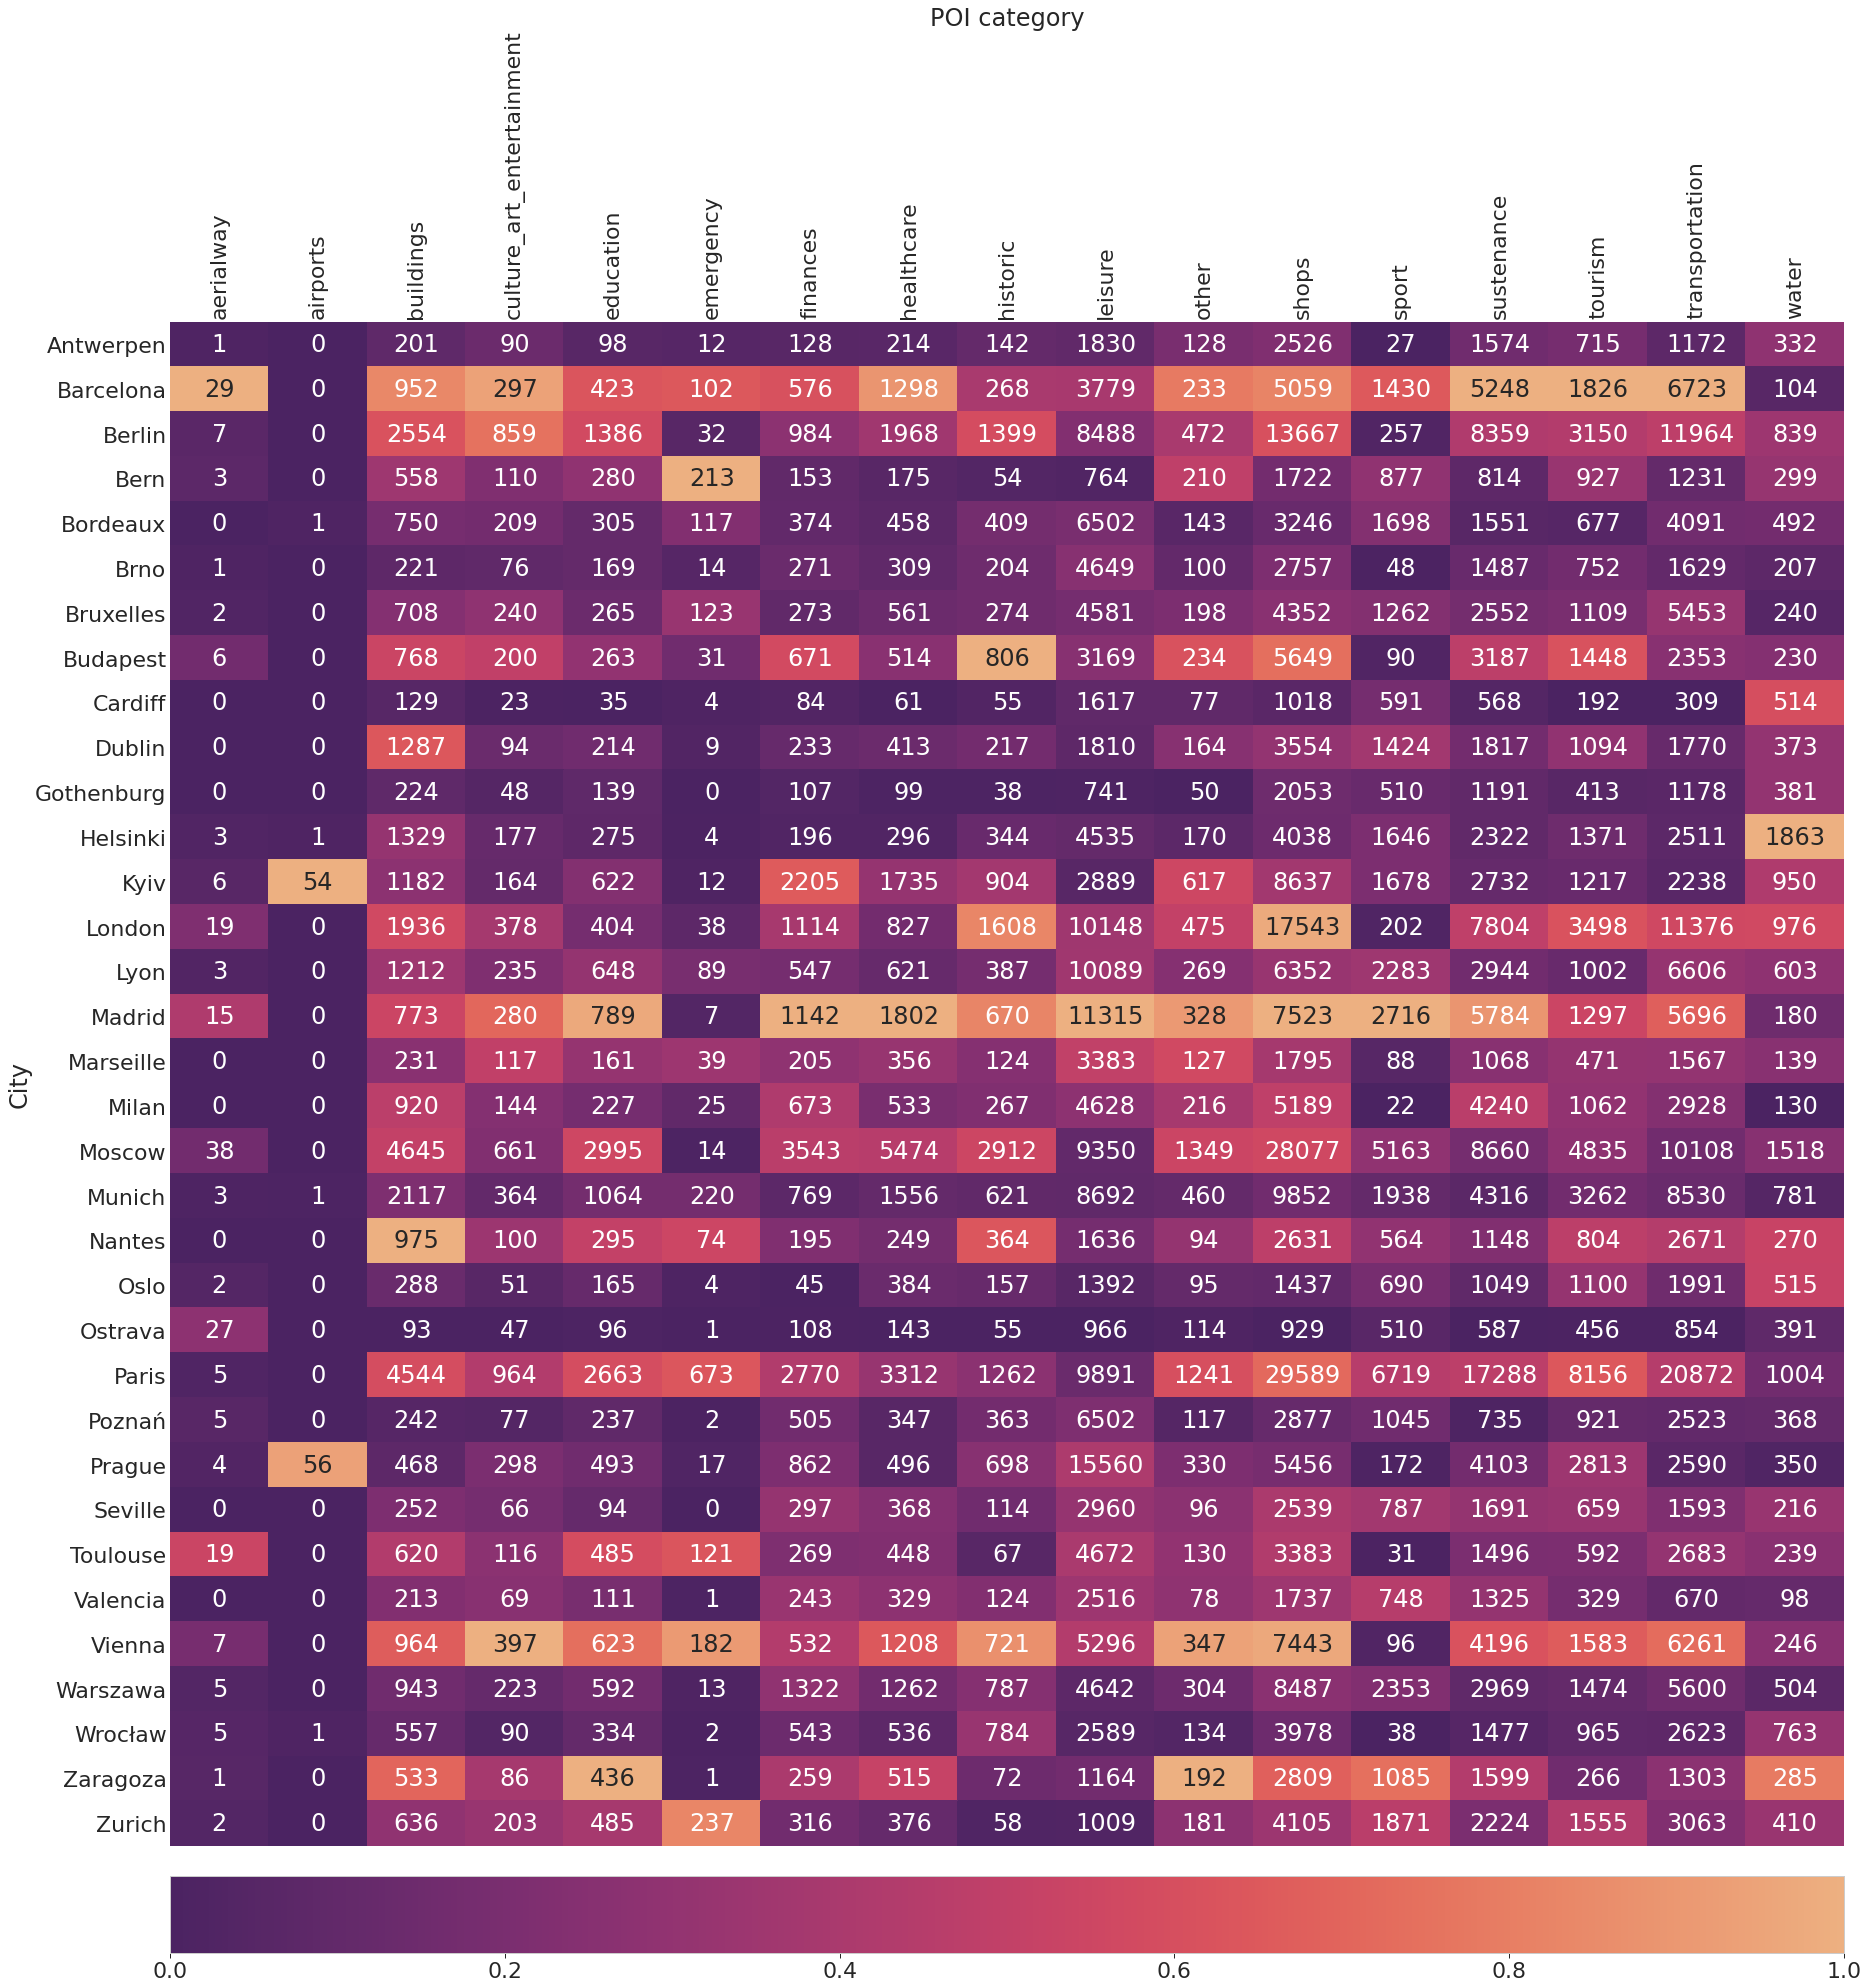

In [104]:
plt.rcParams['xtick.bottom'] = plt.rcParams['xtick.labelbottom'] = False
plt.rcParams['xtick.top'] = plt.rcParams['xtick.labeltop'] = True

# grid_kws = {"height_ratios": (1, .05), "hspace": .3}
# fig, (ax, cbar_ax) = plt.subplots(2, figsize=(10,15), gridspec_kw=grid_kws)

fig = plt.figure(figsize=(30,30))
ax = sns.heatmap(
    data=grpd_norm.round(3),
    # square=True,
    # annot=True,
    annot=grpd,
    fmt='g',
    # ax=ax,
    cmap="flare_r",
    cbar=False,
    # norm=LogNorm()
    # cbar_ax=cbar_ax,
    # cbar_kws={"orientation": "horizontal"},
    # cbar_kws = dict(use_gridspec=False,location="bottom")
)

# ax.set_title(f"\n")

ax.set_xlabel("POI category")
ax.set_ylabel("City")

# ax.xaxis.set_ticks_position('top')
# xticks(range(5), rotation=90, size='xx-large') 
ax.xaxis.set_label_position('top')
ax.tick_params(axis=u'both', which=u'both',length=0)

ax_divider = make_axes_locatable(ax)
# define size and padding of axes for colorbar
cax = ax_divider.append_axes('bottom', size = '5%', pad = '2%')
# make colorbar for heatmap. 
# Heatmap returns an axes obj but you need to get a mappable obj (get_children)
colorbar(ax.get_children()[0], cax = cax, orientation = 'horizontal')
# locate colorbar ticks
cax.xaxis.set_ticks_position('bottom')

# ax.set_yticklabels(stat_ord, rotation = 0)
# ax.set_xticklabels(stat_ord, rotation = 90)

# fig.subplots_adjust(wspace=0.1, hspace=0.55)
# fig.subplots_adjust(top=0.96) # adjust the Figure in rp
# fig.suptitle(f'Prediction quality between the cities\n[Metric: Balanced accuracy]')

# g.set_axis_labels(, )

plt.savefig(f'ea_poi_categories_hex_normed_alt_annot.pdf', dpi=300, format='pdf', bbox_inches='tight')
# plt.savefig(f'transfer_learning_stations_recall.png', dpi=300, format='png', bbox_inches='tight')
plt.show()